<a href="https://colab.research.google.com/github/SiddhiMarri/SHAP_foraudio/blob/main/shap_foraudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


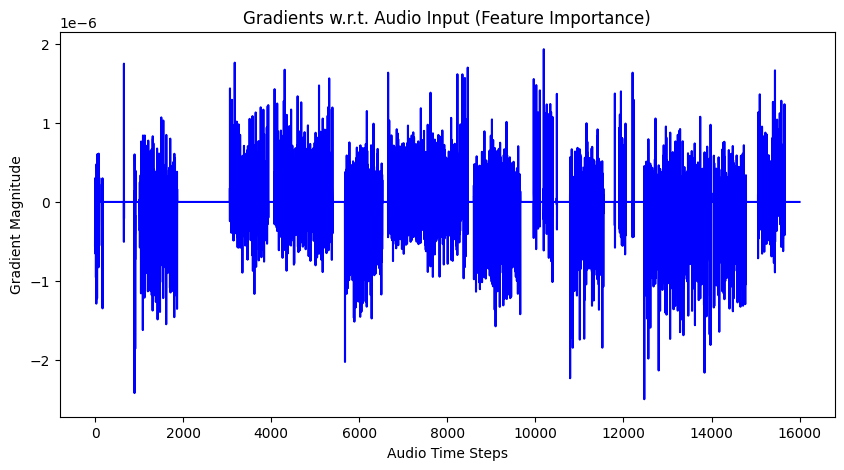

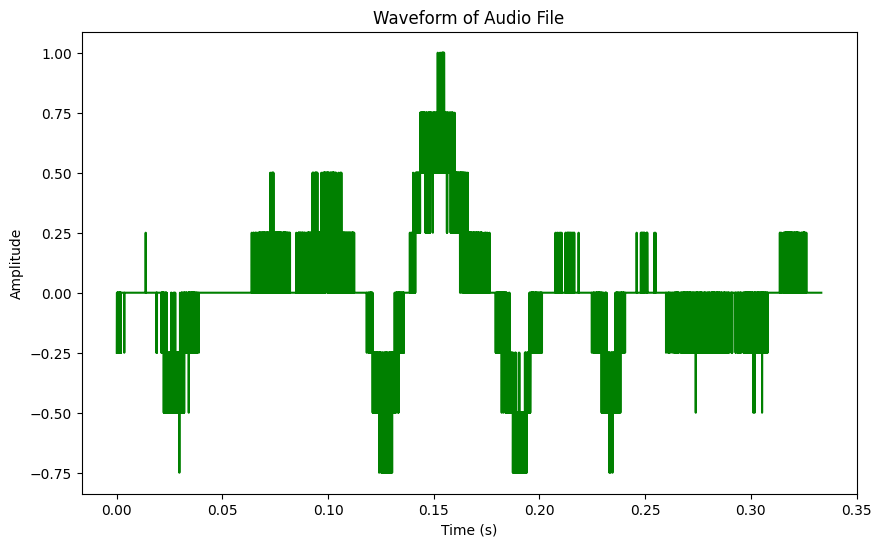

In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import wave

# Load the pre-trained model
model_audio = load_model('/content/model1.h5')

# Function to compute gradients with respect to the input audio
def compute_gradients(model, input_audio, target_class):
    with tf.GradientTape() as tape:
        tape.watch(input_audio)
        predictions = model(input_audio)
        loss = predictions[0, target_class]
    gradients = tape.gradient(loss, input_audio)
    return gradients.numpy()

# Function to load audio file manually without librosa
def load_audio_file(audio_file, target_length=16000):
    with wave.open(audio_file, 'rb') as wf:
        sr = wf.getframerate()
        num_frames = min(target_length, wf.getnframes())
        audio_data = wf.readframes(num_frames)
        audio_np = np.frombuffer(audio_data, dtype=np.int16).astype(np.float32)

    # Normalize audio and pad if needed
    audio_np = audio_np / np.max(np.abs(audio_np))  # Normalization
    if len(audio_np) < target_length:
        audio_np = np.pad(audio_np, (0, target_length - len(audio_np)), "constant")
    audio_np = np.expand_dims(audio_np, axis=0)  # Add batch dimension
    return tf.convert_to_tensor(audio_np, dtype=tf.float32), sr, audio_np[0]  # Tensor and original waveform

# Load and preprocess the audio, calculate gradients
audio_file = "/content/drive/MyDrive/archive (3)/audio_speech_actors_01-24/Actor_13/03-01-08-02-01-01-13.wav"
input_audio, sr, original_audio = load_audio_file(audio_file)
target_class = 13

# Compute gradients
gradients = compute_gradients(model_audio, input_audio, target_class)

# Plot the gradients manually
plt.figure(figsize=(10, 5))
plt.plot(gradients[0], color='blue')
plt.title("Gradients w.r.t. Audio Input (Feature Importance)")
plt.xlabel("Audio Time Steps")
plt.ylabel("Gradient Magnitude")
plt.show()

# Manually plot the waveform without librosa.display
time = np.linspace(0, len(original_audio) / sr, num=len(original_audio))
plt.figure(figsize=(10, 6))
plt.plot(time, original_audio, color='green')
plt.title('Waveform of Audio File')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()


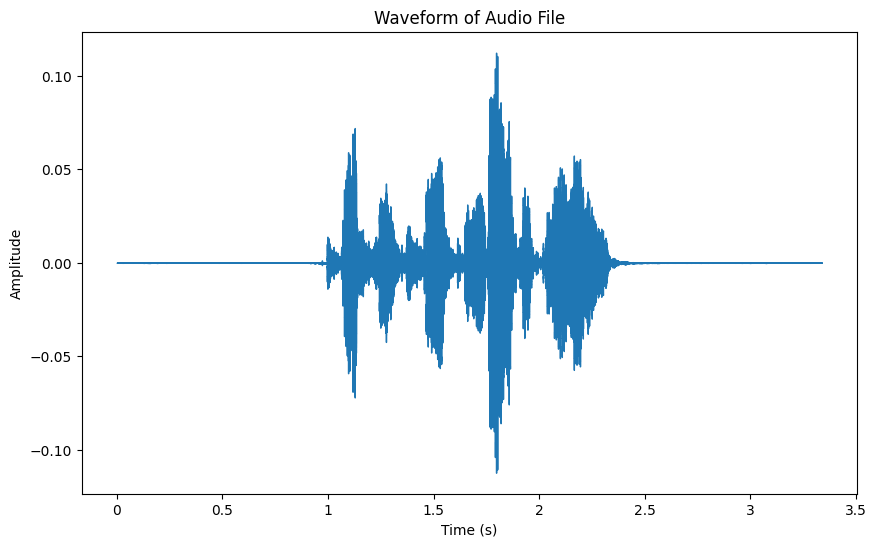

In [ ]:
y, sr = librosa.load(audio_file, sr=16000)

# Plot the waveform
plt.figure(figsize=(10, 6))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform of Audio File')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
data = {
    'path': ['/content/drive/MyDrive/archive (3)/audio_speech_actors_01-24/Actor_13/03-01-08-02-01-01-13.wav'],
    'labels': [13],
    'mfcc_mean': [0.496736],
    'zcr_mean': [0.255654],
    'pitch_mean': [0.85778],
    'chroma_mean': [0.692254],
    'spectral_contrast_mean': [0.300001],
    'hnr_mean': [0.67061],
    'rms_mean': [0.054772],
    'zcr_var': [0.100918],
    'spectral_entropy': [0.713645],
    'tonnetz_mean': [0.389187]
}

In [ ]:
import shap
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
dnn_model=load_model("/content/dnn_model.h5")
input_shape = dnn_model.input_shape
print(f"Input Shape: {input_shape}")
output_shape = dnn_model.output_shape
print(f"Output Shape: {output_shape}")

Input Shape: (None, 10)
Output Shape: (None, 14)


In [ ]:
import numpy as np
import itertools

# Sample data
data = {
    'path': ['/content/drive/MyDrive/archive (3)/audio_speech_actors_01-24/Actor_13/03-01-08-02-01-01-13.wav'],
    'labels': [13],
    'mfcc_mean': [0.496736],
    'zcr_mean': [0.255654],
    'pitch_mean': [0.85778],
    'chroma_mean': [0.692254],
    'spectral_contrast_mean': [0.300001],
    'hnr_mean': [0.67061],
    'rms_mean': [0.054772],
    'zcr_var': [0.100918],
    'spectral_entropy': [0.713645],
    'tonnetz_mean': [0.389187]
}

features = np.array([data['mfcc_mean'][0], data['zcr_mean'][0], data['pitch_mean'][0], data['chroma_mean'][0],
                     data['spectral_contrast_mean'][0], data['hnr_mean'][0], data['rms_mean'][0], data['zcr_var'][0],
                     data['spectral_entropy'][0], data['tonnetz_mean'][0]]).reshape(1, -1)

feature_names = ['mfcc_mean', 'zcr_mean', 'pitch_mean', 'chroma_mean', 'spectral_contrast_mean',
                 'hnr_mean', 'rms_mean', 'zcr_var', 'spectral_entropy', 'tonnetz_mean']
feature_indices = {feat: idx for idx, feat in enumerate(feature_names)}

def shapley_value(model, features, feature_index, min_subset_size=1, verbose=False):
    n_features = features.shape[1]
    remaining_features = [i for i in range(n_features) if i != feature_index]

    subsets_without_feature = list(itertools.chain.from_iterable(
        itertools.combinations(remaining_features, r) for r in range(min_subset_size, len(remaining_features) + 1)
    ))

    shapley_val = 0
    for subset in subsets_without_feature:
        subset_vector = np.zeros((1, 10))
        features_with_vector = np.zeros((1, 10))
        for i in subset:
            subset_vector[0, i] = features[0, i]
        features_with_vector[:, :] = subset_vector[:, :]
        features_with_vector[0, feature_index] = features[0, feature_index]
        prediction_with = model.predict(features_with_vector)
        prediction_without = model.predict(subset_vector)
        marginal_contribution = prediction_with - prediction_without
        shapley_val += marginal_contribution.mean()

    shapley_val /= len(subsets_without_feature)
    return shapley_val

feature_index = 1
shapley_val = shapley_value(dnn_model, features, feature_index)
print(shapley_val)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

In [ ]:
import numpy as np
import itertools

# Sample data
data = {
    'path': ['/content/drive/MyDrive/archive (3)/audio_speech_actors_01-24/Actor_13/03-01-08-02-01-01-13.wav'],
    'labels': [13],
    'mfcc_mean': [0.496736],
    'zcr_mean': [0.255654],
    'pitch_mean': [0.85778],
    'chroma_mean': [0.692254],
    'spectral_contrast_mean': [0.300001],
    'hnr_mean': [0.67061],
    'rms_mean': [0.054772],
    'zcr_var': [0.100918],
    'spectral_entropy': [0.713645],
    'tonnetz_mean': [0.389187]
}

features = np.array([data['mfcc_mean'][0], data['zcr_mean'][0], data['pitch_mean'][0], data['chroma_mean'][0],
                     data['spectral_contrast_mean'][0], data['hnr_mean'][0], data['rms_mean'][0], data['zcr_var'][0],
                     data['spectral_entropy'][0], data['tonnetz_mean'][0]]).reshape(1, -1)

feature_names = ['mfcc_mean', 'zcr_mean', 'pitch_mean', 'chroma_mean', 'spectral_contrast_mean',
                 'hnr_mean', 'rms_mean', 'zcr_var', 'spectral_entropy', 'tonnetz_mean']
feature_indices = {feat: idx for idx, feat in enumerate(feature_names)}

def shapley_value(model, features, feature_index, min_subset_size=5, verbose=False):
    n_features = features.shape[1]
    remaining_features = [i for i in range(n_features) if i != feature_index]

    subsets_without_feature = list(itertools.chain.from_iterable(
        itertools.combinations(remaining_features, r) for r in range(min_subset_size, len(remaining_features) + 1)
    ))

    shapley_val = 0
    for subset in subsets_without_feature:
        subset_vector = np.zeros((1, 10))
        features_with_vector = np.zeros((1, 10))
        for i in subset:
            subset_vector[0, i] = features[0, i]
        features_with_vector[:, :] = subset_vector[:, :]
        features_with_vector[0, feature_index] = features[0, feature_index]
        prediction_with = model.predict(features_with_vector)
        prediction_without = model.predict(subset_vector)
        marginal_contribution = prediction_with - prediction_without
        shapley_val += marginal_contribution.mean()

    shapley_val /= len(subsets_without_feature)
    return shapley_val

feature_index = 6
shapley_val = shapley_value(dnn_model, features, feature_index)
print(shapley_val)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [ ]:
import numpy as np
import itertools

# Sample data
data = {
    'path': ['/content/drive/MyDrive/archive (3)/audio_speech_actors_01-24/Actor_13/03-01-08-02-01-01-13.wav'],
    'labels': [13],
    'mfcc_mean': [0.496736],
    'zcr_mean': [0.255654],
    'pitch_mean': [0.85778],
    'chroma_mean': [0.692254],
    'spectral_contrast_mean': [0.300001],
    'hnr_mean': [0.67061],
    'rms_mean': [0.054772],
    'zcr_var': [0.100918],
    'spectral_entropy': [0.713645],
    'tonnetz_mean': [0.389187]
}

features = np.array([data['mfcc_mean'][0], data['zcr_mean'][0], data['pitch_mean'][0], data['chroma_mean'][0],
                     data['spectral_contrast_mean'][0], data['hnr_mean'][0], data['rms_mean'][0], data['zcr_var'][0],
                     data['spectral_entropy'][0], data['tonnetz_mean'][0]]).reshape(1, -1)

feature_names = ['mfcc_mean', 'zcr_mean', 'pitch_mean', 'chroma_mean', 'spectral_contrast_mean',
                 'hnr_mean', 'rms_mean', 'zcr_var', 'spectral_entropy', 'tonnetz_mean']
feature_indices = {feat: idx for idx, feat in enumerate(feature_names)}

def shapley_value(model, features, feature_index, min_subset_size=5, verbose=False):
    n_features = features.shape[1]
    remaining_features = [i for i in range(n_features) if i != feature_index]

    subsets_without_feature = list(itertools.chain.from_iterable(
        itertools.combinations(remaining_features, r) for r in range(min_subset_size, len(remaining_features) + 1)
    ))

    shapley_val = 0
    for subset in subsets_without_feature:
        subset_vector = np.zeros((1, 10))
        features_with_vector = np.zeros((1, 10))
        for i in subset:
            subset_vector[0, i] = features[0, i]
        features_with_vector[:, :] = subset_vector[:, :]
        features_with_vector[0, feature_index] = features[0, feature_index]
        prediction_with = model.predict(features_with_vector)
        prediction_without = model.predict(subset_vector)
        marginal_contribution = prediction_with - prediction_without
        shapley_val += marginal_contribution.mean()

    shapley_val /= len(subsets_without_feature)
    return shapley_val

feature_index = 6
shapley_val = shapley_value(dnn_model, features, feature_index)
print(shapley_val)
